# Proyecto 1

Juan Camilo Sánchez – 201519337

Zharet Bautista Montes – 201812763

Leonel Andrés Polanía Arias - 201720141

## 1. Importación de librerias

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
import numpy as np
import pandas as pd
import re

#import contractions
import nltk
nltk.download("stopwords")
nltk.download("averaged_perceptron_tagger")
nltk.download("universal_tagset")
from nltk.corpus import stopwords

from sklearn.model_selection import train_test_split

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
# Para crear el arbol de decisión 
from sklearn.tree import DecisionTreeClassifier 
# Para evaluar el modelo
from sklearn.metrics import confusion_matrix, classification_report, precision_score, recall_score, f1_score, accuracy_score
from sklearn.metrics import plot_confusion_matrix
# Para búsqueda de hiperparámetros
from sklearn.model_selection import GridSearchCV
# Para la validación cruzada
from sklearn.model_selection import KFold 
#Librerías para la visualización
import matplotlib.pyplot as plt


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package universal_tagset to /root/nltk_data...
[nltk_data]   Package universal_tagset is already up-to-date!


## 2. Carga de datos

In [4]:
df = pd.read_csv('drive/MyDrive/Reviews.csv')

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 568454 entries, 0 to 568453
Data columns (total 10 columns):
 #   Column                  Non-Null Count   Dtype 
---  ------                  --------------   ----- 
 0   Id                      568454 non-null  int64 
 1   ProductId               568454 non-null  object
 2   UserId                  568454 non-null  object
 3   ProfileName             568438 non-null  object
 4   HelpfulnessNumerator    568454 non-null  int64 
 5   HelpfulnessDenominator  568454 non-null  int64 
 6   Score                   568454 non-null  int64 
 7   Time                    568454 non-null  int64 
 8   Summary                 568427 non-null  object
 9   Text                    568454 non-null  object
dtypes: int64(5), object(5)
memory usage: 43.4+ MB


## 3. Preparación de Datos

- Pasar a minúscula
- Expandir las contracciones 
- Eliminar stopwords
- Concatenar

In [6]:
STOPWORDS = set(stopwords.words('english'))
def lower(text):
    return text.lower()

In [7]:
df["Words"] = df["Text"] + df["Summary"]
df_clean=df.drop(['Id', 'ProductId', 'UserId', 'ProfileName' , 'Time',"Text","Summary"], axis=1)
df_clean['Words'] = df_clean['Words'].astype(str).apply(lower)

In [8]:
df_clean.head(10)

,HelpfulnessNumerator,HelpfulnessDenominator,Score,Words
0,1,1,5,i have bought several of the vitality canned d...
1,0,0,1,product arrived labeled as jumbo salted peanut...
2,1,1,4,this is a confection that has been around a fe...
3,3,3,2,if you are looking for the secret ingredient i...
4,0,0,5,great taffy at a great price. there was a wid...
5,0,0,4,i got a wild hair for taffy and ordered this f...
6,0,0,5,this saltwater taffy had great flavors and was...
7,0,0,5,this taffy is so good. it is very soft and ch...
8,1,1,5,right now i'm mostly just sprouting this so my...
9,0,0,5,this is a very healthy dog food. good for thei...


In [9]:
initialVectorizer = CountVectorizer()
BoW=initialVectorizer.fit_transform(df_clean["Words"])
allwords = initialVectorizer.get_feature_names()
print(len(initialVectorizer.get_feature_names()))
tags = nltk.pos_tag(allwords, tagset='universal')
noValid = [word[0] for word in tags if word[1] not in ["VERB","ADJ"]]
delete = set.union(set(noValid), STOPWORDS)
print(str(len(noValid)))

142082
116149


In [10]:
BoW=initialVectorizer.fit_transform(df_clean["Words"])
BoW.shape

(568454, 142082)

In [11]:
def dropcols_coo(M, idx_to_drop):
    idx_to_drop = np.unique(idx_to_drop)
    C = M.tocoo()
    keep = ~np.in1d(C.col, idx_to_drop)
    C.data, C.row, C.col = C.data[keep], C.row[keep], C.col[keep]
    C.col -= idx_to_drop.searchsorted(C.col)    # decrement column indices
    C._shape = (C.shape[0], C.shape[1] - len(idx_to_drop))
    return C.tocsr()

In [12]:
sum_words = BoW.sum(axis=0) 
words_freq = [word for idx,word in enumerate(initialVectorizer.get_feature_names()) if sum_words[0,idx]<500]
print(len(words_freq))
delete = np.unique(set.union(delete, words_freq))

137582


In [13]:
indexs=[]
BoWords=[]
for i,word in enumerate(initialVectorizer.get_feature_names()):
    if word in delete:
      indexs.append(i)
    else:
      BoWords.append(word)
newBoW= dropcols_coo(BoW,indexs)
print(newBoW.shape)

(568454, 142082)


In [14]:
newBoW.shape

(568454, 142082)

##4.Construccion del Modelo

In [15]:
# Se selecciona la variable objetivo, en este caso "Score".
Y = df_clean.drop(['HelpfulnessNumerator','HelpfulnessDenominator','Words'], axis=1)
X = newBoW

In [16]:
# Dividir los datos en entrenamiento y test
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=0)

In [42]:
# se fijan 3 particiones.
particiones = KFold(n_splits=3, shuffle=True, random_state = 0)
param_grid = {'criterion':['gini','entropy'],'max_depth':[3,4,6,8,10,15,20],'min_samples_split':[2,3,4,5]}
# se crea el modelo vacio
arbol = DecisionTreeClassifier(random_state=0)
bestModel = GridSearchCV(arbol, param_grid, cv=particiones)

In [ ]:
# Se empieza el ajuste del modelo
bestModel.fit(X_train, Y_train)

In [44]:
# los parametros serian
bestModel.best_params_

{'criterion': 'gini', 'max_depth': 20, 'min_samples_split': 4}

In [45]:
# se saca el ultimo modelo
arbol_def = bestModel.best_estimator_
# se pasa el grupo de prueba.
y_pred_train = arbol_def.predict(X_train)
y_pred_test = arbol_def.predict(X_test)
print('Exactitud entrenamiento: %.2f' % accuracy_score(Y_train, y_pred_train))
print('Exactitud test: %.2f' % accuracy_score(Y_test, y_pred_test))

Exactitud entrenamiento: 0.73
Exactitud test: 0.70


In [48]:
# Se genera la matriz de confusión
confusion_matrix(Y_test, y_pred_test)

array([[ 5270,   111,   249,   469,  4168],
       [ 1822,   616,   393,   549,  2805],
       [ 1463,    85,  1803,  1091,  4008],
       [ 1023,    92,   440,  3936, 10738],
       [ 2388,   157,   552,  1818, 67645]])

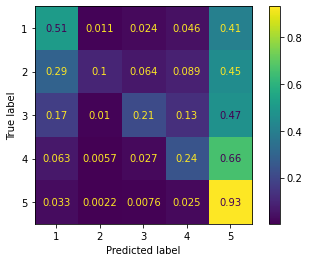

In [49]:
# Se puede visualizar la matriz de confusión
plot_confusion_matrix(arbol_def, X_test, Y_test, normalize='true')  
plt.show()  

In [50]:
print(classification_report(Y_test, y_pred_test, target_names=['1','2','3','4', '5']))

              precision    recall  f1-score   support

           1       0.44      0.51      0.47     10267
           2       0.58      0.10      0.17      6185
           3       0.52      0.21      0.30      8450
           4       0.50      0.24      0.33     16229
           5       0.76      0.93      0.84     72560

    accuracy                           0.70    113691
   macro avg       0.56      0.40      0.42    113691
weighted avg       0.66      0.70      0.65    113691

